## (1) Import libraries

In [58]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE

pl.seed_everything(6)

Global seed set to 6


6

In [59]:
# Record version of key libraries
from importlib.metadata import version

print('pytorch_lightning==%s' % version('pytorch_lightning'))
print('pytorch_forecasting==%s' % version('pytorch_forecasting'))

pytorch_lightning==1.2.10
pytorch_forecasting==0.9.0


## (2) Get data

In [62]:
# Read local data
uni_data_df = pd.read_csv("../data/air_passengers.csv")
uni_data_df = uni_data_df.sort_values('ds') # must ensure row is sorted by time

# NOTE - For real value predictions, must use float. Using int will lead to categorical predictions.
uni_data_df['y'] = uni_data_df['y'].astype(float)

# Create an time index column, with incremental time step
uni_data_df = uni_data_df.reset_index()

# Create a data sample group column
uni_data_df['group_index'] = 'grp_1'

# Define parameters
max_encoder_length = 36 # determine time window for x - how many time steps to generate predictions
max_prediction_length = 12 # determine time window for y - how many time steps of predictions to generate
batch_size = 12
training_proportion = 0.75

# Get date for training data cut off
training_cutoff_date = uni_data_df['ds'][uni_data_df.shape[0] * training_proportion]

# Get training and validation data
uni_train_df = uni_data_df[uni_data_df['ds']<training_cutoff_date]
uni_valid_df = uni_data_df[uni_data_df['ds']>=training_cutoff_date]

# Convert into pytorch-lightning data type
# Create training dataset
uni_training_ts = TimeSeriesDataSet(
    uni_train_df,
    time_idx='index',
    target='y',
    group_ids=['group_index'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['y']
)

# Create validation dataset
uni_validation_ts = TimeSeriesDataSet.from_dataset(
    uni_training_ts, 
    uni_data_df, 
    min_prediction_idx=uni_training_ts.index.time.max() + 1, 
    stop_randomization=True)

# Create dataloaders for model training
train_dataloader = uni_training_ts.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = uni_validation_ts.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

## (3) Tune model

In [63]:
# Define trainer
trainer = pl.Trainer(
    gpus=0, 
    gradient_clip_val=0.01
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [64]:
# Create the model
# NOTE - N-BEATS is a deep learning model designed for solving univariate time series forecasting
net = NBeats.from_dataset(
    uni_training_ts,
    learning_rate=3e-2, 
    weight_decay=1e-2, 
    widths=[32, 512], 
    backcast_loss_ratio=0.1
)

print(f"Number of parameters in network: {net.size():.1f}")

Number of parameters in network: 1661376.0



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.646     Total estimated model params size (MB)
/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers w

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/c/Users/cheey/Desktop/working_directory/experiment_lab/timeseries_analysis/notebooks/lr_find_temp_model.ckpt


Suggested learning rate: 0.015848931924611138


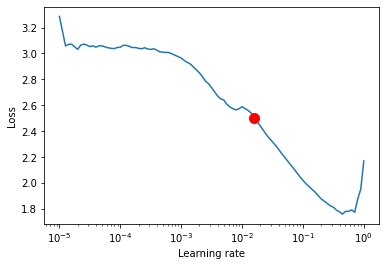

In [65]:
# Find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = trainer.tuner.lr_find(
    net, 
    train_dataloader=train_dataloader, 
    val_dataloaders=val_dataloader, 
    min_lr=1e-5
)

print(f"Suggested learning rate: {res.suggestion()}")

fig = res.plot(show=True, suggest=True)
fig.show()

# Get suggested learning rate
# net.hparams.learning_rate = res.suggestion()
suggested_lr = res.suggestion()

## (4) Fit model

In [66]:
# Define trainer with early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10, 
    verbose=False, 
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)

# Create the model
net = NBeats.from_dataset(
    uni_training_ts,
    learning_rate=suggested_lr,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.646     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## (5) Evaluate results

In [67]:
# Get best model
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

# Get actuals
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# Generate best model predictions
predictions = best_model.predict(val_dataloader)

# Compare best model predictions with actuals for validation
best_model_smape = SMAPE()(predictions, actuals)

# Calculate baseline predictions - naive prediction using last value
baseline_predictions = Baseline().predict(val_dataloader)

# Compare baseline model predictions with actuals for validation
baseline_model_smape = SMAPE()(baseline_predictions, actuals)

print('SMAPE for baseline model prediction : %s' % baseline_model_smape)
print('SMAPE for best model prediction : %s' % best_model_smape)

SMAPE for baseline model prediction : tensor(0.1691)
SMAPE for best model prediction : tensor(0.0554)


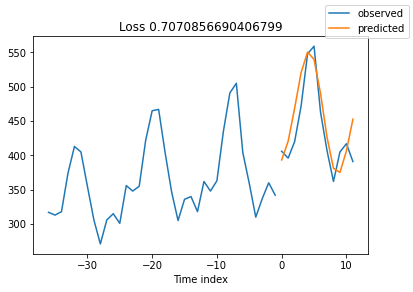

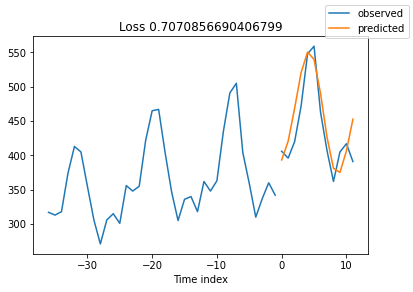

In [68]:
# Plot predictions
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

# Get initial prediction time point
init_time_idx = uni_training_ts.index.time.max() + 1 # plot from validation data onwards

best_model.plot_prediction(
    x, raw_predictions, 
    idx=init_time_idx,
    add_loss_to_title=True
)

# for idx in range(10):  # Plot 10 examples by moving starting point by one time step ahead
#     best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

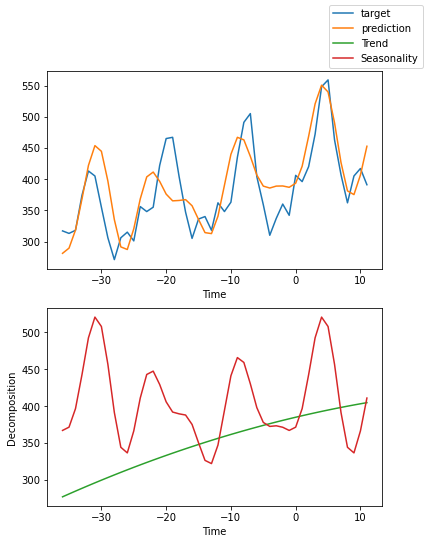

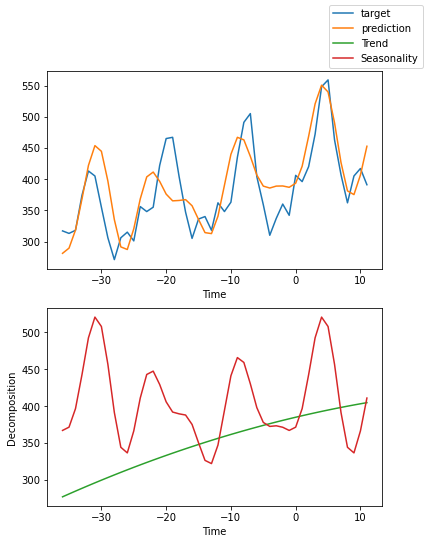

In [69]:
# Decompose predictions into seasonality and trend
# NOTE - only possible with NBeats

best_model.plot_interpretation(x, raw_predictions, idx=init_time_idx)